# bafiq plots for publishing

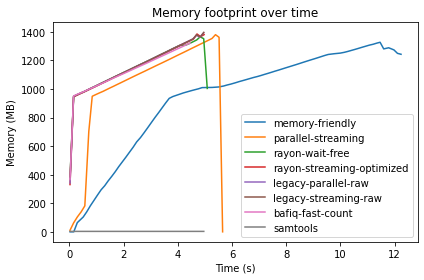

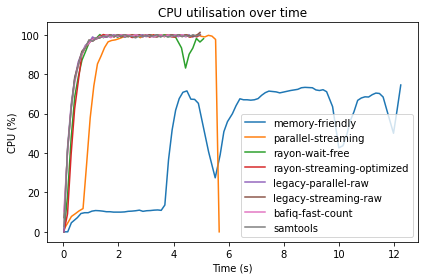

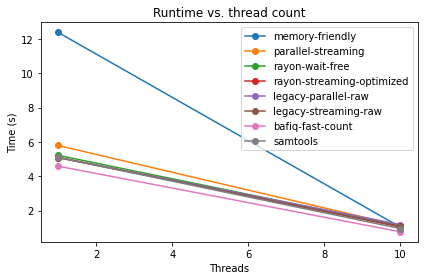

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ---------------------------------------------------------------------------
# 1.  Load data
# ---------------------------------------------------------------------------
MEM_FILE   = Path("benchmark_results/memory_samples.csv")
THREAD_FILE = Path("benchmark_results/thread_scaling.csv")

mem_df    = pd.read_csv(MEM_FILE)
thread_df = pd.read_csv(THREAD_FILE)

# Helper: convert timestamp (ms → s) once so we can reuse it
mem_df = mem_df.assign(time_s = mem_df["timestamp_ms"] / 1_000.0)

# ---------------------------------------------------------------------------
# 2.  Functions that generate each chart
# ---------------------------------------------------------------------------
def plot_memory_over_time(df: pd.DataFrame, threads: int | None = None) -> None:
    """
    Memory footprint of each strategy over wall-clock time.
    If *threads* is given, only samples taken with that thread count are shown.
    """
    use = df if threads is None else df[df["threads"] == threads]

    plt.figure()
    for strat, grp in use.groupby("strategy", sort=False):
        plt.plot(grp["time_s"], grp["memory_mb"], label=strat)

    plt.title("Memory footprint over time")
    plt.xlabel("Time (s)")
    plt.ylabel("Memory (MB)")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_cpu_over_time(df: pd.DataFrame, threads: int | None = None) -> None:
    """
    CPU utilisation of each strategy over wall-clock time.
    Values above 100 % mean multiple cores are in use.
    """
    use = df if threads is None else df[df["threads"] == threads]

    plt.figure()
    for strat, grp in use.groupby("strategy", sort=False):
        plt.plot(grp["time_s"], grp["cpu_percent"], label=strat)

    plt.title("CPU utilisation over time")
    plt.xlabel("Time (s)")
    plt.ylabel("CPU (%)")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_runtime_vs_threads(df: pd.DataFrame, seconds: bool = True) -> None:
    """
    End-to-end runtime for every strategy as a function of thread count.
    Set *seconds=False* to keep milliseconds on the y-axis.
    """
    plt.figure()
    for strat, grp in df.groupby("strategy", sort=False):
        grp_sorted = grp.sort_values("threads")
        y = grp_sorted["time_ms"] / 1_000.0 if seconds else grp_sorted["time_ms"]
        plt.plot(grp_sorted["threads"], y, marker="o", label=strat)

    plt.title("Runtime vs. thread count")
    plt.xlabel("Threads")
    plt.ylabel("Time (s)" if seconds else "Time (ms)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ---------------------------------------------------------------------------
# 3.  Example usage – feel free to tweak
# ---------------------------------------------------------------------------

# (a) One-thread runs only, to keep the plot uncluttered
plot_memory_over_time(mem_df, threads=1)

# (b) CPU utilisation (also one-thread runs)
plot_cpu_over_time(mem_df, threads=1)

# (c) Thread-scaling – all available points
plot_runtime_vs_threads(thread_df)

## CPU and MEM over time


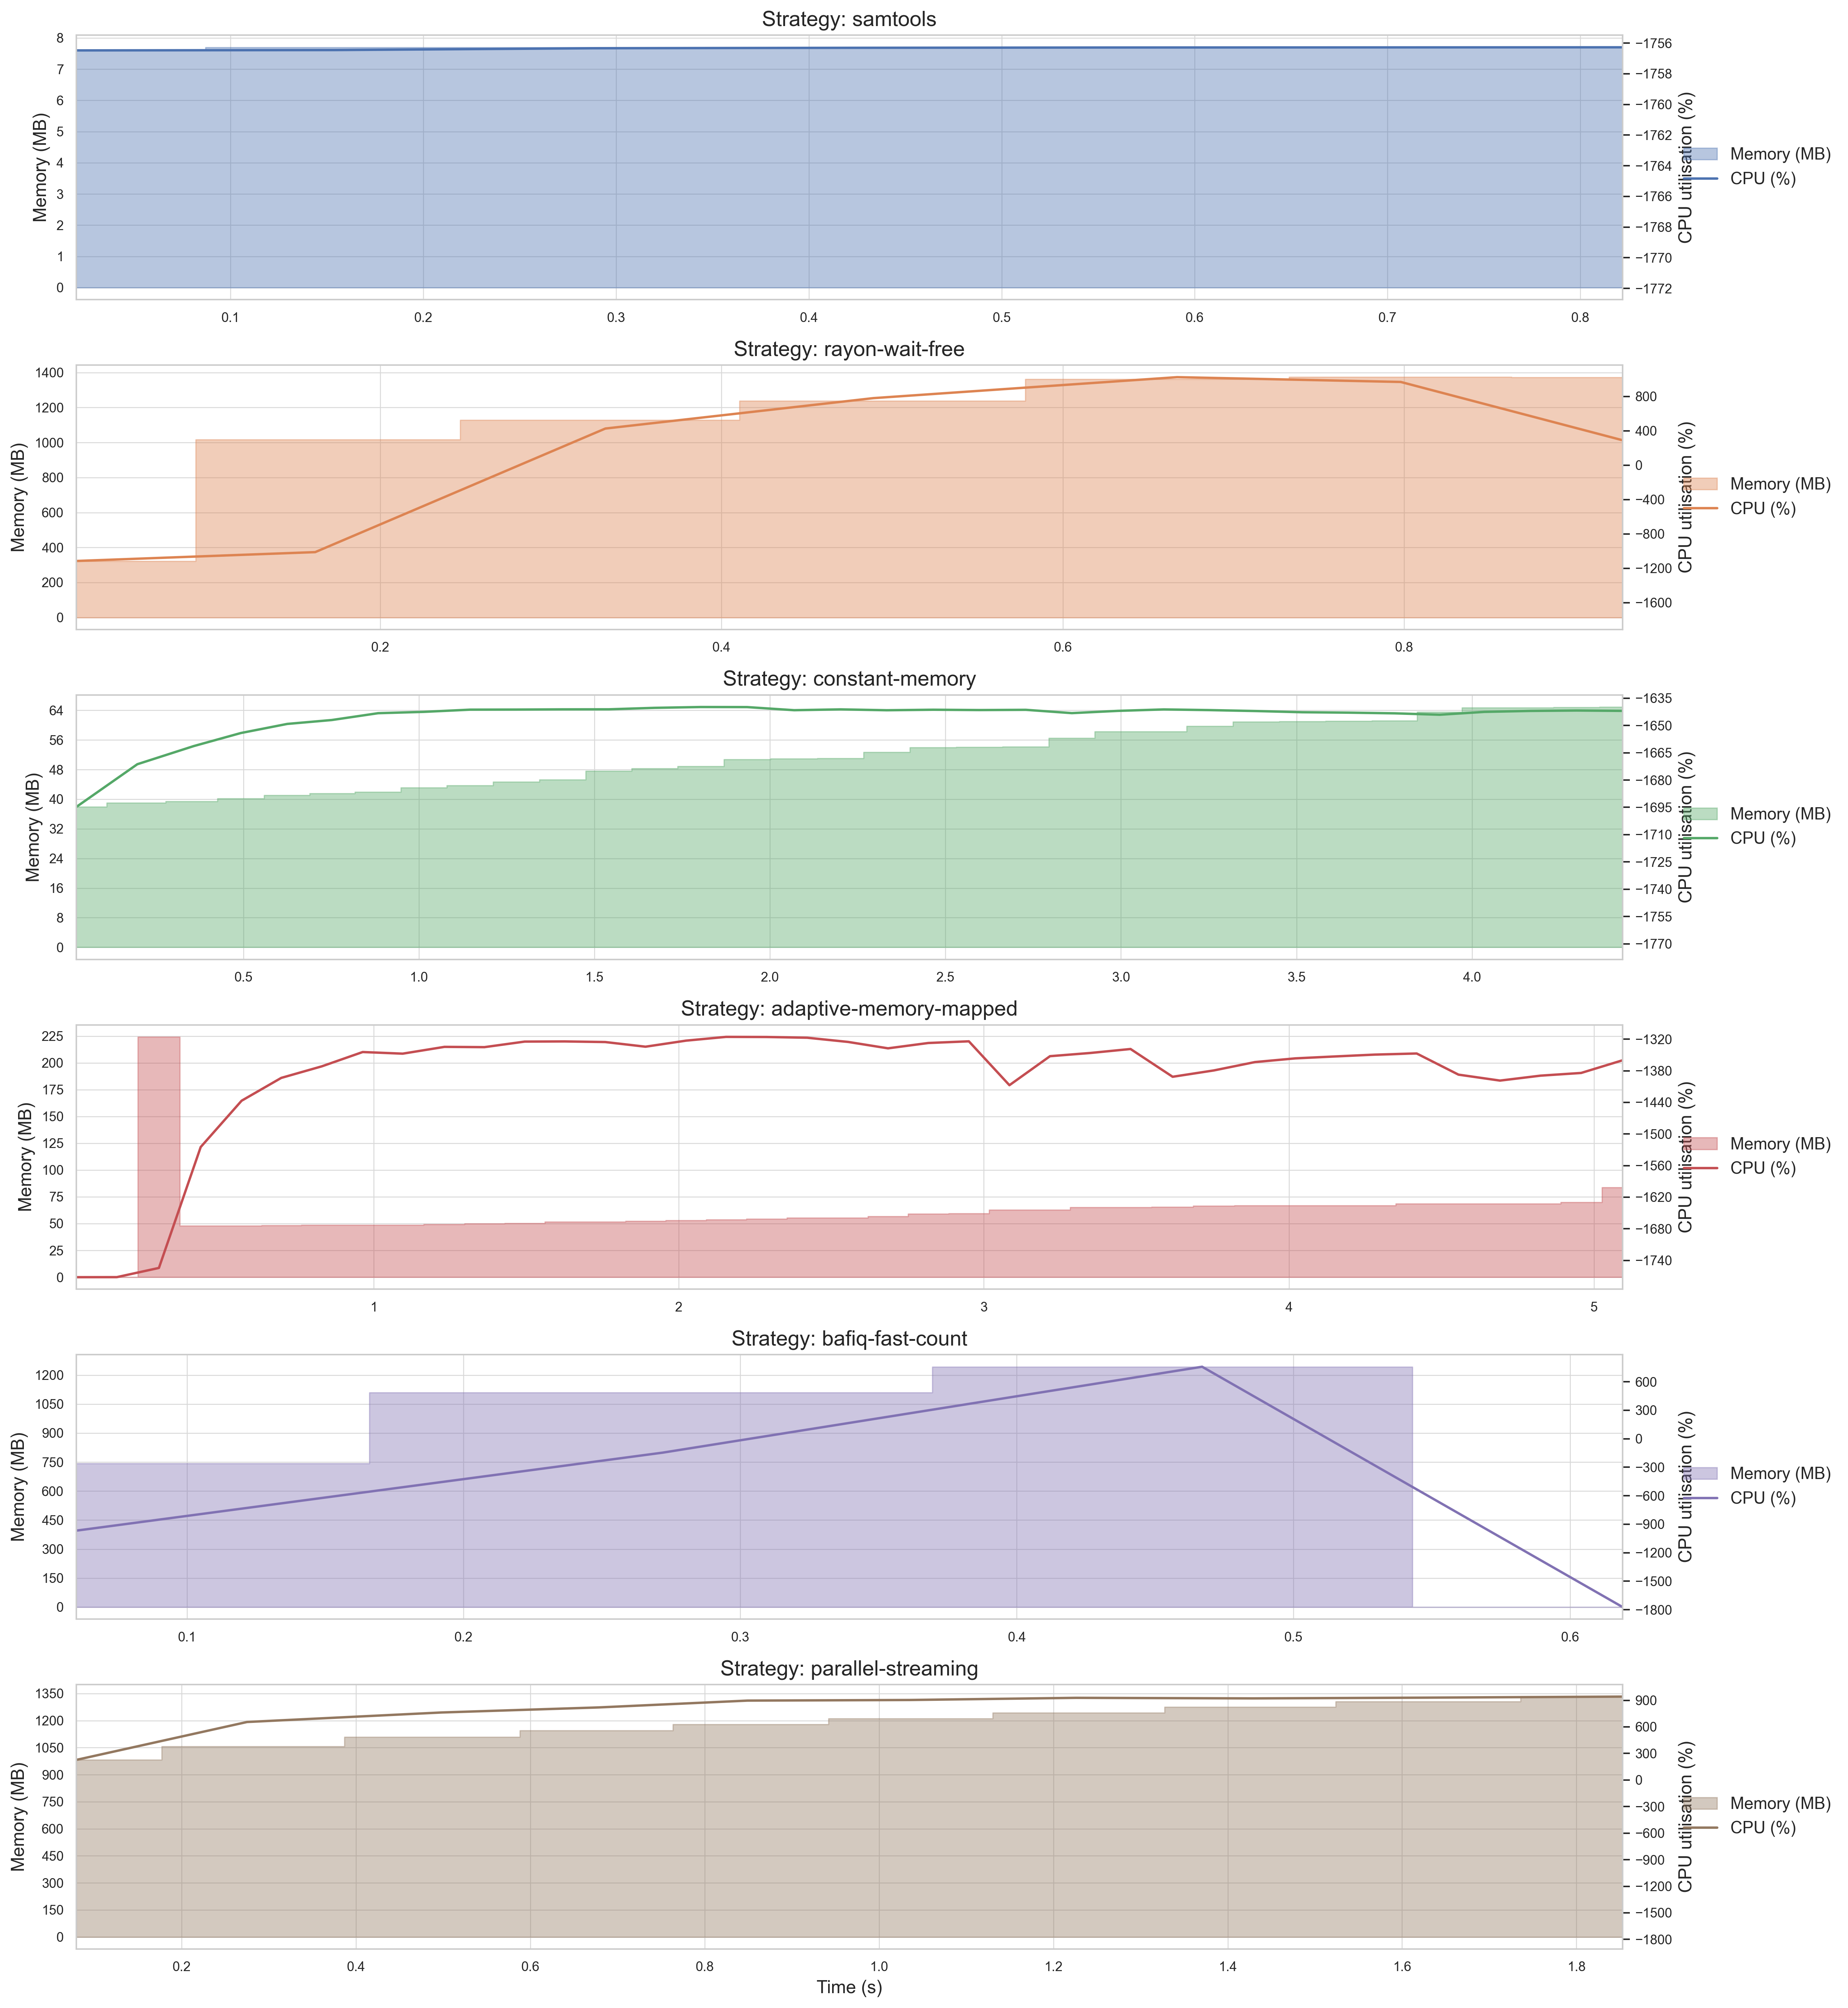

In [1]:
# -*- coding: utf-8 -*-
"""
Multiplot (Seaborn style) with aligned dual y-axes
==================================================

* x-axis ........... wall-clock time (s)
* left y-axis ...... memory allocation (MB) – shaded area
* right y-axis ..... CPU utilisation (%) – line
* One subplot per strategy, stacked vertically
* Print-ready 300-dpi PNG output
"""

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

# -------------------------------------------------------------------------
# 1.  Load CSV and tidy up
# -------------------------------------------------------------------------
CSV = Path("benchmark_results/memory_samples_20250706_193712.csv")        # ⬅ change if necessary
df  = pd.read_csv(CSV)

df["time_s"] = df["timestamp_ms"] / 1_000.0           # ms → s
df = df.sort_values("time_s")

# -------------------------------------------------------------------------
# 2.  Global aesthetics (Seaborn “whitegrid” + font boost)
# -------------------------------------------------------------------------
sns.set_theme(style="whitegrid", context="paper")
plt.rcParams.update({
    "figure.figsize":  (7.2, 4.0),
    "axes.titlesize":  14,
    "axes.labelsize":  12,
    "font.size":       11,
    "legend.fontsize": 11,
    "grid.color":      "#d8d8d8",
    "grid.linewidth":  0.6,
})

# -------------------------------------------------------------------------
# 3.  Build the multiplot
# -------------------------------------------------------------------------
strategies     = df["strategy"].unique()
n              = len(strategies)
fig_height     = 3.1 * n
fig, axes = plt.subplots(nrows=n, figsize=(10, fig_height), dpi=300)

# Make axes iterable even when n == 1
axes = axes if isinstance(axes, (list, np.ndarray)) else [axes]

palette = sns.color_palette()

for ax, strat, colour in zip(axes, strategies, palette):
    sub = df[df["strategy"] == strat]

    # ---------------------------------------------------------------------
    # LEFT AXIS  ➜  memory area
    # ---------------------------------------------------------------------
    ax.set_xlim(sub["time_s"].min(), sub["time_s"].max())     # independent span
    ax.fill_between(sub["time_s"], sub["memory_mb"], step="mid",
                    alpha=0.40, color=colour, label="Memory (MB)")
    ax.set_ylabel("Memory (MB)")
    ax.set_title(f"Strategy: {strat}")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    # ---------------------------------------------------------------------
    # RIGHT AXIS  ➜  CPU line (aligned grid)
    #            1. derive linear transform  cpu → mem
    #            2. plot transformed CPU on *left* axis
    #            3. attach secondary axis showing true CPU %
    # ---------------------------------------------------------------------
    mem_min, mem_max = sub["memory_mb"].min(), sub["memory_mb"].max()
    cpu_min, cpu_max = sub["cpu_percent"].min(), sub["cpu_percent"].max()

    # Guard against zero ranges
    mem_span = mem_max - mem_min if mem_max != mem_min else 1
    cpu_span = cpu_max - cpu_min if cpu_max != cpu_min else 1

    scale  = mem_span / cpu_span
    offset = mem_min - cpu_min * scale

    cpu2mem = lambda c: c * scale + offset          # → memory units
    mem2cpu = lambda m: (m - offset) / scale        # ← CPU units (inverse)

    # Plot CPU line (converted to memory units) on the LEFT axis
    ax.plot(sub["time_s"],
            cpu2mem(sub["cpu_percent"]),
            color=colour,
            linewidth=1.6,
            label="CPU (%)")

    # Add the *aligned* secondary axis
    secax = ax.secondary_yaxis('right', functions=(mem2cpu, cpu2mem))
    secax.set_ylabel("CPU utilisation (%)")
    secax.yaxis.set_major_locator(MaxNLocator(integer=True))

    # Shared legend (place it just outside the right edge)
    ax.legend(loc="center left", bbox_to_anchor=(1.03, 0.5), frameon=False)

# -------------------------------------------------------------------------
# 4.  Final touches & export
# -------------------------------------------------------------------------
axes[-1].set_xlabel("Time (s)")
plt.tight_layout()
plt.subplots_adjust(right=1.5)          # margin for the legends

fig.savefig("benchmark_multiplot.png", dpi=300, bbox_inches="tight")
plt.show()

## CPU mem overlay

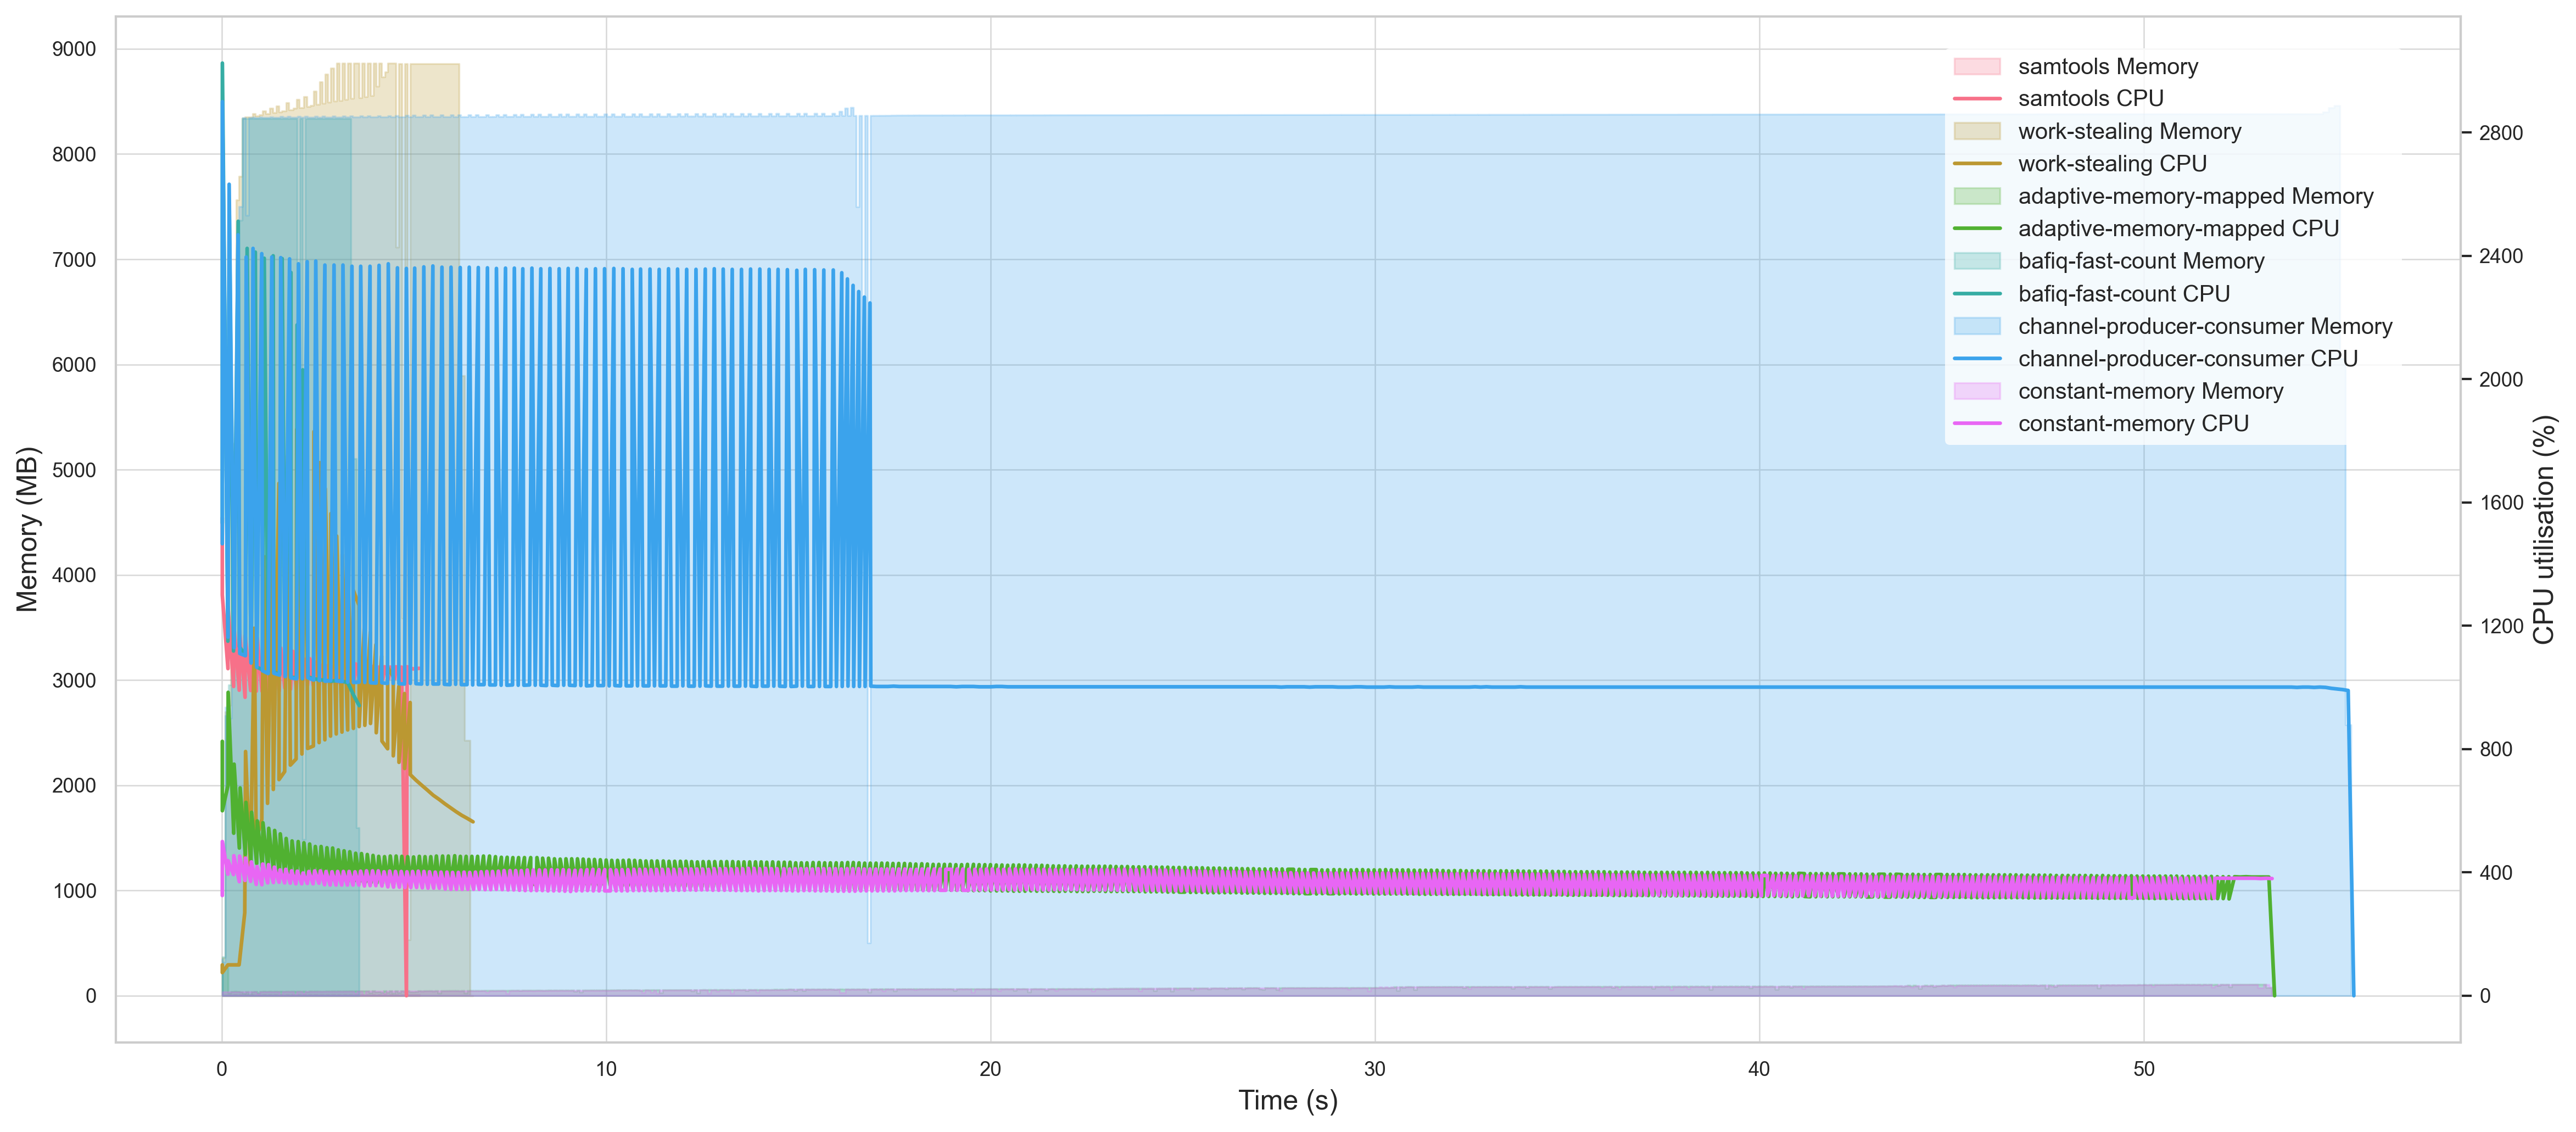

In [14]:
# -*- coding: utf-8 -*-
"""
Single-plot overlay: memory (area) + CPU (line) for all strategies
=================================================================
"""

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

# ------------------------------------------------------------
# 1.  Load CSV
# ------------------------------------------------------------
CSV = Path("benchmark_results/memory_samples_20250706_200513.csv")  # <— adjust
df  = pd.read_csv(CSV)
df["time_s"] = df["timestamp_ms"] / 1_000.0
df = df.sort_values("time_s")

strategies = df["strategy"].unique()
n          = len(strategies)

# ------------------------------------------------------------
# 2.  Global look & feel
# ------------------------------------------------------------
sns.set_theme(style="whitegrid", context="paper")
plt.rcParams.update({
    "figure.figsize":  (15, 7),
    "axes.titlesize":  14,
    "axes.labelsize":  12,
    "font.size":       11,
    "legend.fontsize": 10,
    "grid.color":      "#d8d8d8",
    "grid.linewidth":  0.6,
})

# ------------------------------------------------------------
# 3.  One set of axes + aligned dual-axis transform
# ------------------------------------------------------------
fig, ax = plt.subplots(dpi=300)

# -- derive *global* linear transform so CPU grid aligns with memory grid
mem_min, mem_max = df["memory_mb"].min(), df["memory_mb"].max()
cpu_min, cpu_max = df["cpu_percent"].min(), df["cpu_percent"].max()
mem_span = mem_max - mem_min or 1
cpu_span = cpu_max - cpu_min or 1

scale  = mem_span / cpu_span
offset = mem_min - cpu_min * scale

cpu2mem = lambda c: c * scale + offset          # CPU → memory units
mem2cpu = lambda m: (m - offset) / scale        # inverse

# -- colour palette, one hue per strategy
palette = sns.color_palette("husl", n) 

for colour, strat in zip(palette, strategies):
    sub = df[df["strategy"] == strat]

    # Memory area (left axis)
    ax.fill_between(sub["time_s"],
                    sub["memory_mb"],
                    step="mid",
                    alpha=0.25,
                    color=colour,
                    label=f"{strat} Memory")

    # CPU line (transformed to memory units, plotted on left axis)
    ax.plot(sub["time_s"],
            cpu2mem(sub["cpu_percent"]),
            color=colour,
            linewidth=1.6,
            label=f"{strat} CPU")

# Labels & axis formatting
ax.set_xlabel("Time (s)")
ax.set_ylabel("Memory (MB)")
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

secax = ax.secondary_yaxis("right", functions=(mem2cpu, cpu2mem))
secax.set_ylabel("CPU utilisation (%)")
secax.yaxis.set_major_locator(MaxNLocator(integer=True))

# Legend outside the plot
ax.legend(
    loc="upper right",            # inside plot, top-right
    bbox_to_anchor=(0.98, 0.98),  # slight padding from edges
    frameon=True,
    facecolor="white",
    edgecolor="none",
    fontsize=10
)

plt.tight_layout()
plt.subplots_adjust(right=1)          # room for legend
fig.savefig("benchmark_overlay.png", dpi=300, bbox_inches="tight")
plt.show()